# Advanced Spatial Analyis II - Data Challenge
### Adrian Hauser 17-715-962

In [81]:
#Imports
import pandas as pd
import geopandas as gpd
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
from typing import List
import matplotlib.pyplot as plt

In [3]:
# Import Data
def import_csv(path:str, datetime_columns:List[str]=None, space_replacement:str=None) -> pd.DataFrame:
    '''
    Imports a .csv from path, has option to specify datetime-columns and characters to replace spaces in field names.
    :param path: String containing path to .csv file.
    :param datetime_columns: Specify datetime columns to cast them on inport.
    :param underscore_replacement: Optional replacement character for spaces in field names.
    :return:
    '''

    df = pd.read_csv('{}'.format(path), parse_dates=datetime_columns)

    if space_replacement:
        df.columns = df.columns.str.replace(' ', space_replacement)
    return df

df = import_csv(
    path=r'C:\Users\adria\Documents\8_GEO_FS23\GEO881_Advanced_Spatial_Analysis_II\201903-citibike-tripdata.csv',
    datetime_columns=['starttime','stoptime'],
    space_replacement='_')


In [13]:
# 1. How many trips are reported in the date?
print(len(df))

1327960


In [39]:
# 2. What is the earliest time of the day any trip starts?
def get_earliest_time(series:pd.Series) -> dt.time:
    '''
    Gets earliest time of a datetime series.
    :param series: Series containing datetimes.
    :return: Returns dt.time of the earliest time.
    '''
    return min(series.dt.time)

print(get_earliest_time(df.starttime))

00:00:00.236000


In [40]:
# 3. How many stations are used?
def count_unique_values(df:pd.DataFrame, columns:List[str]) -> int:
    '''
    Counts unique values across one or multiple columns in a DataFrame.
    :param df: Input DataFrame containing columns you want to get the count of unique values.
    :return: Returns an integer indicating the number of unique values across the column(s).
    '''

    for i, column in enumerate(columns):
        if i==0:
            df_concat = df[column]
        else:
            df_concat = pd.concat([df_concat, df[column]])

    return df_concat.nunique()

count = count_unique_values(df=df, columns=['start_station_id', 'end_station_id'])
print(count)

773


In [43]:
# 4. What is the mean number of trips per day?
def count_rows_per_day(df:pd.DataFrame, column:str) -> pd.DataFrame:
    return df.groupby(df[column].dt.day).size().reset_index()

trips_per_day = count_rows_per_day(df, 'starttime')
print(trips_per_day.mean())

starttime       16.000000
0            42837.419355
dtype: float64


,starttime,0
0,1,30233
1,2,18001
2,3,23239
3,4,28421
4,5,37097
5,6,33279
6,7,35907
7,8,40406
8,9,38928
9,10,18897


In [42]:
# 5. What ist the mean number of trips on Sundays?
df_sunday = df[df.starttime.dt.dayofweek == 6]
df_sunday.groupby(df_sunday.starttime.dt.day).size().mean()

starttime       16.000000
0            42837.419355
dtype: float64


32406.8

In [8]:
# 6. On which day did most trips start?
df_trips = df.groupby(df.starttime.dt.date).size().idxmax()
print(df_trips)

2019-03-30


In [9]:
# How many trips did start that day

# Get the subset on the specific day
df_most_trips = df[df.starttime.dt.date == df_trips]

# Set starttime to index to use .between_time()
df_most_trips.set_index('starttime', inplace=True)
len(df_most_trips.between_time(start_time='11:00', end_time='15:00'))

23162

In [10]:
# What is the duration of the longest trip?
str(timedelta(seconds=max(df.tripduration)))

'34 days, 8:56:21'

In [11]:
# 9. What is the 99% quantile of trip durations
str(timedelta(seconds=df.tripduration.quantile(q= 0.99)))

'0:52:11'

<AxesSubplot: ylabel='Frequency'>

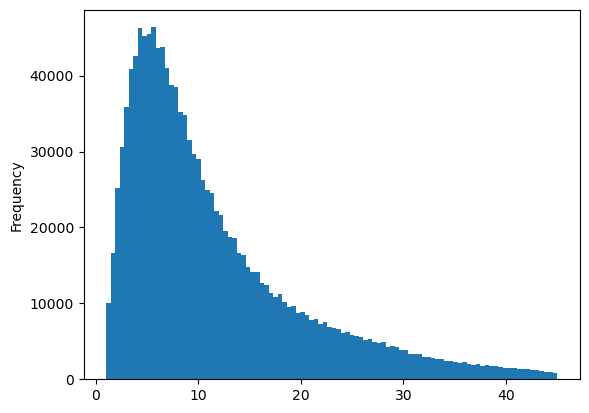

In [12]:
# 10. Plot a histogram of all trips shorter than 45 minutes
df_shorter = df[df.tripduration/60 <= 45]['tripduration']/60
df_shorter.plot.hist(bins=100)

In [5]:
# 11. What is the median beeline distance travelled
def calculate_distance_from_coordinates(df:pd.DataFrame, start_lat, start_lon, end_lat, end_lon):

    # Calculate distance in KM
    df['distance'] = df.apply(lambda row: geodesic((row[start_lat], row[start_lon]), (row[end_lat], row[end_lon])), axis=1)
    # Remove unit and cast to float and multiply by 1000 to get meters
    df['distance']=df['distance'].astype(str).str[:-3].astype(float)
    df['distance'] = df['distance']*1000

    return df

df = calculate_distance_from_coordinates(
    df=df,
    start_lat='start_station_latitude',
    start_lon='start_station_longitude',
    end_lat='end_station_latitude',
    end_lon='end_station_longitude')


print(f'{df.distance.median()} meters')

1299.9714521791336 meters


(0.0, 3000.0)

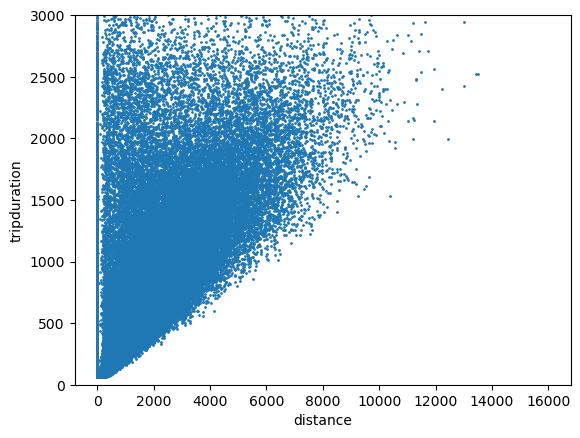

In [97]:
# 12. Generate a sub-sample containing a random 10% of the data, and for that subsample plot the time to ride the (beeline) distance.

df_subset = df[['distance', 'tripduration']].sample(frac=0.1)

ax = df_subset.plot.scatter(x='distance', y='tripduration',s=1)
ax.set_ylim(0,3000)

In [9]:
# 13. Plot a map indicating the 10 most and least active stations.

# Get activity measure: Occurence of the station in start or stop

# Make a dataframe containing all stations and their geometries
start_stations = df[['start_station_id', 'start_station_longitude', 'start_station_latitude']]
end_stations =df[['end_station_id', 'end_station_longitude', 'end_station_latitude']]

start_stations.rename(columns={'start_station_id':'station_id', 'start_station longitude':'lon', 'start_station_latitude':'lat'}, inplace=True)
end_stations.rename(columns={'end_station_id':'station_id', 'end_station_longitude':'lon', 'end_station_latitude':'lat'}, inplace=True)

stations = pd.concat([start_stations, end_stations])

C:\Users\adria\AppData\Local\Temp\ipykernel_8396\3761723496.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_stations.rename(columns={'start_station_id':'station_id', 'start_station longitude':'lon', 'start_station_latitude':'lat'}, inplace=True)
C:\Users\adria\AppData\Local\Temp\ipykernel_8396\3761723496.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_stations.rename(columns={'end_station_id':'station_id', 'end_station_longitude':'lon', 'end_station_latitude':'lat'}, inplace=True)


In [10]:
# Count the occurence of the stations
stations_count = stations.groupby(['station_id', 'lon', 'lat']).size().to_frame('activity').reset_index()

# Get the stations with the 10 smallest and 10 largest counts
stations_active = stations_count.nsmallest(10, 'activity')
stations_active = pd.concat([stations_active, stations_count.nlargest(10, 'activity')])

In [11]:
stations_active

,station_id,lon,lat,activity
398,3196.0,-74.043991,40.744319,1
413,3250.0,-73.983838,40.716910,1
420,3276.0,-74.042817,40.714584,1
397,3184.0,-74.033552,40.714145,2
280,3040.0,-73.994980,40.669800,8
411,3245.0,-73.982331,40.716444,24
268,2005.0,-73.971001,40.705312,49
748,3704.0,-73.941765,40.743752,64
605,3512.0,-73.933789,40.774718,74
649,3559.0,-73.939122,40.757631,81


In [67]:
# Create a geodataframe
gdf = gpd.GeoDataFrame(
    stations_active, geometry=gpd.points_from_xy(stations_active.lon, stations_active.lat))
gdf = gdf.set_crs('epsg:4326')
gdf = gdf.to_crs(3857)

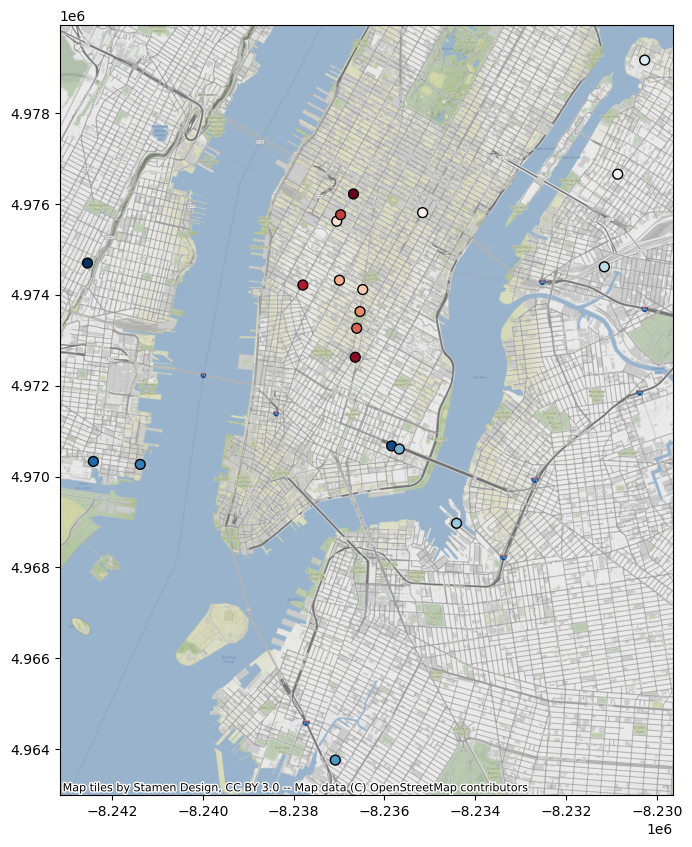

In [92]:
# Plot the points
import contextily as cx

ax = gdf.plot(figsize=(10, 10), alpha=1, edgecolor='k', c=gdf.activity, markersize =50,marker='o', cmap='RdBu_r')
cx.add_basemap(ax, zoom=15)